In [73]:
from PRAN import PRAN

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [88]:
df = pd.read_csv('../data/hepatitis.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df.head()

,Class,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,0,30,2,1,2,2,2,2,1,2,2,2,2,2,1.0,85.000000,18.0,4.0,61.852273,1
1,0,50,1,1,2,1,2,2,1,2,2,2,2,2,0.9,135.000000,42.0,3.5,61.852273,1
2,0,78,1,2,2,1,2,2,2,2,2,2,2,2,0.7,96.000000,32.0,4.0,61.852273,1
3,0,31,1,2,1,2,2,2,2,2,2,2,2,2,0.7,46.000000,52.0,4.0,80.000000,1
4,0,34,1,2,2,2,2,2,2,2,2,2,2,2,1.0,105.325397,200.0,4.0,61.852273,1


In [94]:
random_state = 1

from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(df.drop(['Class'], axis = 1), df['Class'], test_size=0.2, random_state=random_state)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train_pos = X_train[np.where(y_train == 1)[0]]
X_test_pos = X_test[np.where(y_test == 1)[0]]
y_train_pos = np.where(y_train == 1)[0]
y_test_pos = np.where(y_test == 1)[0]

In [96]:
tensor_x = torch.Tensor(X_train_pos)
tensor_y = torch.Tensor(y_train_pos)

tensor_x_test = torch.Tensor(X_test_pos)
tensor_y_test = torch.Tensor(y_test_pos)

train_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(tensor_x_test,tensor_y_test)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [97]:
from RecallBooster import RecallBooster
from RecallBooster import mseLoss

D_in = X_train.shape[1]
H = 50
H2 = 12
model = RecallBooster(D_in, H, H2)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

loss_mse = mseLoss()

In [98]:
epochs = 2000
log_interval = 50
val_losses = []
train_losses = []
test_losses = []

In [99]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_x, batch_y in trainloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch_x)
        loss = loss_mse(recon_batch, batch_x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    if epoch % 200 == 0:        
        print('====> Epoch: {} Average training loss: {:.4f}'.format(
            epoch, train_loss / len(trainloader.dataset)))
        train_losses.append(train_loss / len(trainloader.dataset))

In [100]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        for batch_x, batch_y in testloader:
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch_x)
            loss = loss_mse(recon_batch, batch_x, mu, logvar)
            test_loss += loss.item()
            if epoch % 200 == 0:        
                print('====> Epoch: {} Average test loss: {:.4f}'.format(
                    epoch, test_loss / len(testloader.dataset)))
            test_losses.append(test_loss / len(testloader.dataset))

In [101]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

====> Epoch: 200 Average training loss: 29.1525
====> Epoch: 200 Average test loss: 25.8956
====> Epoch: 400 Average training loss: 25.2257
====> Epoch: 400 Average test loss: 20.4653
====> Epoch: 600 Average training loss: 23.7694
====> Epoch: 600 Average test loss: 17.3976
====> Epoch: 800 Average training loss: 19.0334
====> Epoch: 800 Average test loss: 18.6688
====> Epoch: 1000 Average training loss: 18.9184
====> Epoch: 1000 Average test loss: 19.0876
====> Epoch: 1200 Average training loss: 17.4192
====> Epoch: 1200 Average test loss: 19.3230
====> Epoch: 1400 Average training loss: 16.4926
====> Epoch: 1400 Average test loss: 19.9262
====> Epoch: 1600 Average training loss: 16.6025
====> Epoch: 1600 Average test loss: 20.0771
====> Epoch: 1800 Average training loss: 16.4014
====> Epoch: 1800 Average test loss: 19.5721
====> Epoch: 2000 Average training loss: 16.3115
====> Epoch: 2000 Average test loss: 21.9169


In [102]:
with torch.no_grad():
    for batch_x, batch_y in testloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch_x)

recon_row = sc.inverse_transform([recon_batch[0].cpu().numpy()])
real_row = sc.inverse_transform([tensor_x_test[0].cpu().numpy()])
cols = df_pos.drop(['Class'], axis = 1).columns
bruh = np.stack((recon_row, real_row)).reshape(2, 19)
df = pd.DataFrame(bruh, columns = cols)
df

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER BIG,LIVER FIRM,SPLEEN PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY
0,57.220104,1.014527,1.089634,1.824198,0.989545,1.097815,1.826431,1.939845,1.858114,1.748753,1.106901,1.797747,1.972804,1.937569,103.986837,107.841092,3.641016,41.651775,1.918617
1,61.999999,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,105.325397,59.999999,3.817266,61.852273,1.000000


In [103]:
sigma = torch.exp(logvar/2)
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

In [104]:
with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

In [105]:
fake_data = sc.inverse_transform(pred)
fake_data.shape

(20, 19)

In [111]:
y_train_fake = pd.Series([1 for i in range(no_samples)])

In [119]:
X_train_generated = np.vstack((X_train, pred))
y_train_generated = np.hstack((y_train, y_train_fake))

In [122]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def getScores(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    print("-----" + name + " scores-----")
    print("Accuracy: " + str(model.score(X_test, y_test)))
    print("Precision: " + str(precision_score(y_test, y_pred)))
    print("Recall: " + str(recall_score(y_test, y_pred)))

    display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, name=name
    )
    _ = display.ax_.set_title(name + " Precision-Recall curve")
    cm = confusion_matrix(y_test, y_pred, labels = model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print("\n")

def testAllModels(X_train, y_train, X_test, y_test):

    lr = LogisticRegression(random_state=1)
    svm = SVC(random_state=1)
    gnb = GaussianNB()
    knn = KNeighborsClassifier()
    dt = DecisionTreeClassifier()

    lr.fit(X_train, y_train)
    svm.fit(X_train, y_train)
    gnb.fit(X_train, y_train)
    knn.fit(X_train, y_train)
    dt.fit(X_train, y_train)

    getScores("Logistic Regression", lr, X_test, y_test)
    getScores("Support Vector Machine", svm, X_test, y_test)
    getScores("Gaussian Naive Bayes", gnb, X_test, y_test)
    getScores("K Nearest Neighbors", knn, X_test, y_test)
    getScores("Decision Trees", dt, X_test, y_test)

-----Logistic Regression scores-----
Accuracy: 0.8387096774193549
Precision: 0.5
Recall: 0.4


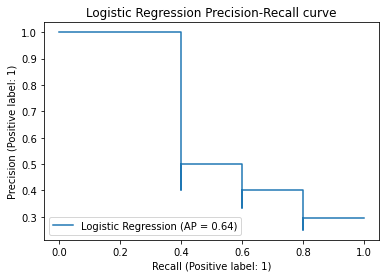

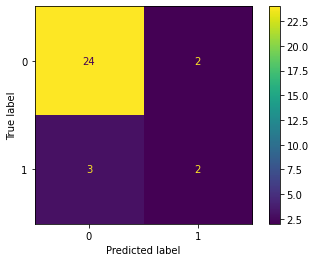



-----Support Vector Machine scores-----
Accuracy: 0.8709677419354839
Precision: 0.6666666666666666
Recall: 0.4


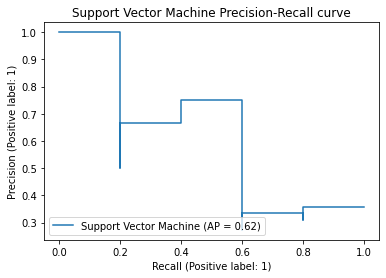

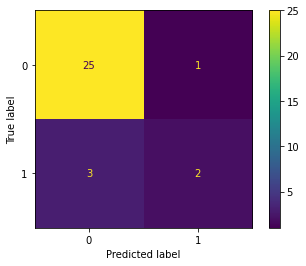



-----Gaussian Naive Bayes scores-----
Accuracy: 0.6451612903225806
Precision: 0.3125
Recall: 1.0


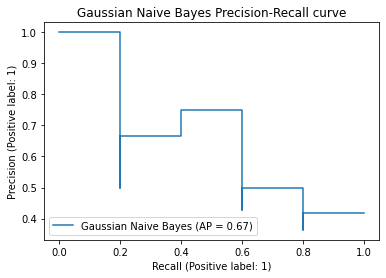

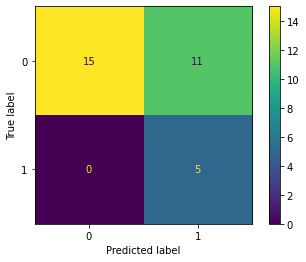



-----K Nearest Neighbors scores-----
Accuracy: 0.8387096774193549
Precision: 0.5
Recall: 0.2


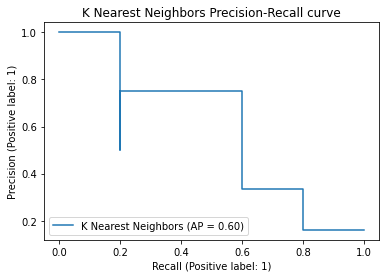

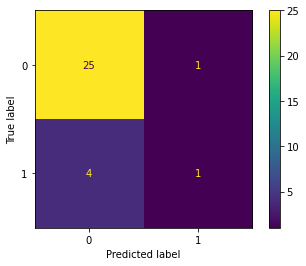



-----Decision Trees scores-----
Accuracy: 0.7741935483870968
Precision: 0.25
Recall: 0.2


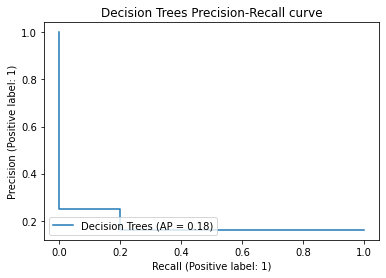

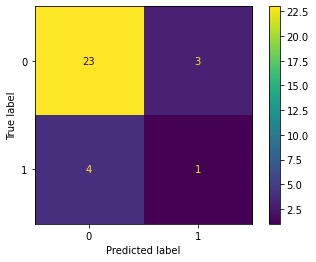

In [123]:
testAllModels(X_train, y_train, X_test, y_test)

-----Logistic Regression scores-----
Accuracy: 0.8709677419354839
Precision: 0.6
Recall: 0.6


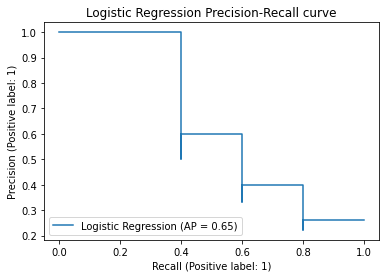

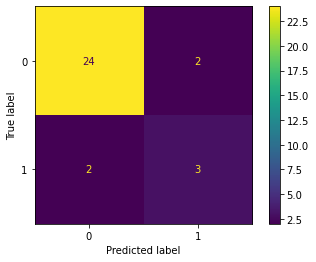



-----Support Vector Machine scores-----
Accuracy: 0.8709677419354839
Precision: 0.6666666666666666
Recall: 0.4


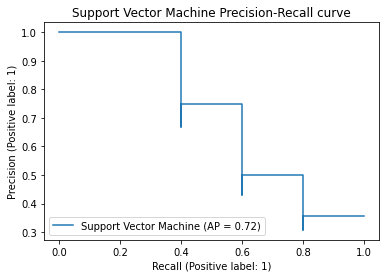

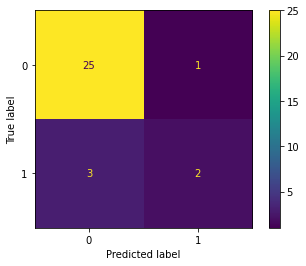



-----Gaussian Naive Bayes scores-----
Accuracy: 0.8387096774193549
Precision: 0.5
Recall: 0.6


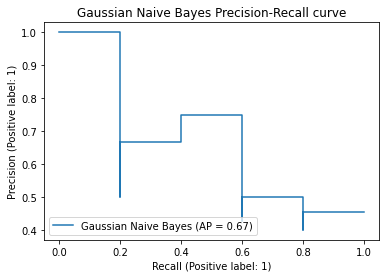

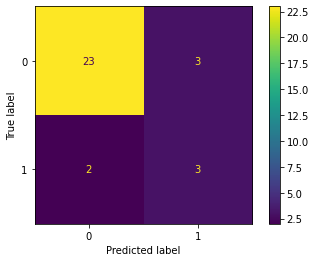



-----K Nearest Neighbors scores-----
Accuracy: 0.8709677419354839
Precision: 0.6
Recall: 0.6


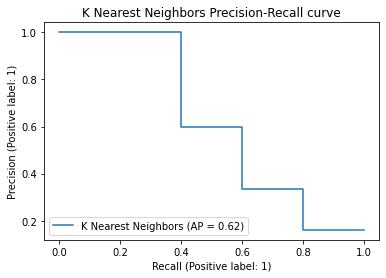

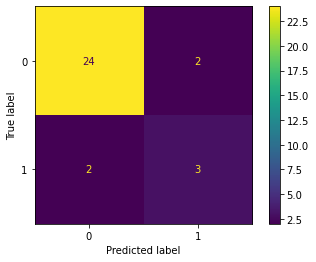



-----Decision Trees scores-----
Accuracy: 0.7741935483870968
Precision: 0.3333333333333333
Recall: 0.4


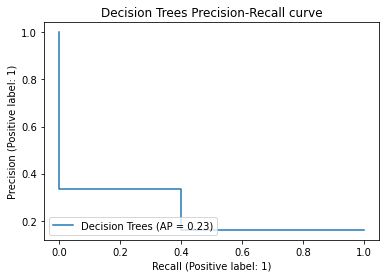

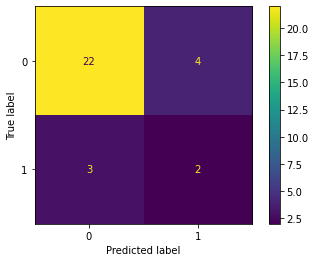

In [124]:
testAllModels(X_train_generated, y_train_generated, X_test, y_test)